In [1]:
from functools import partial

import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from typing import List

For some special cases, we can find an analytic solution.

In [2]:

# special case for analytic solution
tau_mem = 1e-2
tau_syn = 5e-3

tau_mem_inv = 1 / tau_mem
tau_syn_inv = 1 / tau_syn

v_leak = 0.0
v_th = 0.3


def spike_time(weights, input_spikes):
    exp_spike_times_syn = np.exp(input_spikes / tau_syn)
    exp_spike_times_mem = np.exp(input_spikes / tau_mem)

    eps = 1e-6
    factor_a1 = np.matmul(weights, exp_spike_times_syn)  # + eps
    factor_a2 = np.matmul(weights, exp_spike_times_mem)
    factor_c = v_th - v_leak

    factor_sqrt = np.sqrt(factor_a2 ** 2 - 4 * factor_a1 * factor_c)

    ret_val = 2. * tau_syn * np.log(2. * factor_a1 / (factor_a2 + factor_sqrt))
    ret_val = np.where(np.isnan(ret_val), 2*tau_mem, ret_val)
    return ret_val

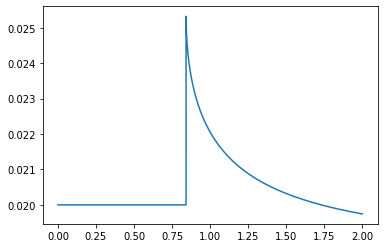

In [3]:
# how does the spike time depeneds on the weight?
st = partial(spike_time, input_spikes=np.array([tau_syn, 2*tau_mem]))

weights = np.arange(0.0, 2.0, 1e-4)
input = np.repeat(weights, 2).reshape(-1, 2)  
times = jax.vmap(st)(input)
# for i in input:
#     st(i)

plt.plot(weights, times)
plt.show()

In [14]:
def heaviside(x):
  return 0.5 + 0.5 * np.sign(x)

def kernel(A, t, t0):
  return heaviside(t - t0) * jax.scipy.linalg.expm(A * (t - t0))

def f(A, t0, x0, t):
  return np.einsum("ijk, ik -> j", jax.vmap(partial(kernel, A, t))(t0), x0)  # np.stack((np.zeros_like(x0), x0), axis=1))


Second input spike at voltage: 0.239 and current: 0.868
Spike time: 0.00560 at voltage: 0.29999998211860657


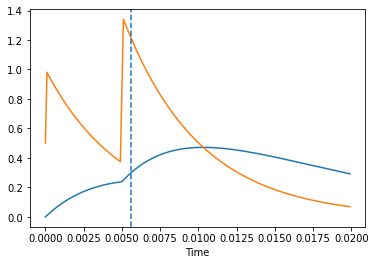

In [15]:
A = np.array([[-tau_mem_inv, tau_mem_inv], [0, -tau_syn_inv]])

tk = np.array([0., 5e-3])
xk = np.array([[0.0, 1.0], [0.0, 1.0]])

ts = np.arange(0.0, 0.02, 1e-4)
ys = jax.vmap(partial(f, A, tk, xk), in_axes=0)(ts)

t_spike = spike_time(xk[:,1], tk)  
gradient = jax.grad(spike_time)(xk[:, 1], tk)  

dynamics = partial(f, A, tk, xk)
print(f"Second input spike at voltage: {dynamics(tk[1:])[0]:.3f} and current: {dynamics(tk[1:])[1]:.3f}")
print(f"Spike time: {t_spike:.5f} at voltage: {partial(f, A, tk, xk)(t_spike)[0]}")
plt.xlabel('Time')
plt.plot(ts, ys)
plt.axvline(t_spike, linestyle='--')  

We can replicate this with only the second spike if we also spike the voltage.

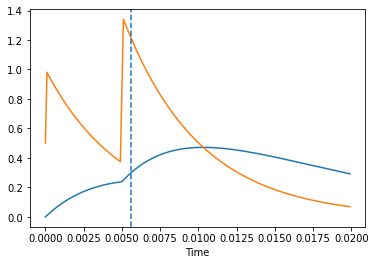

In [16]:
tk = np.array([5e-3])
xk = np.array([[0.239, 1.368]])

def dynamics(state, t):
    v_0, i_0 = state[0]
    i_new = i_0 * np.exp(-t / tau_syn)
    tau_frac = (tau_syn / (tau_syn - tau_mem))
    v_new = tau_frac * i_0 * np.exp(-t/tau_syn) + (v_0 - tau_frac * i_0) * np.exp(-t/tau_mem)
    return np.array([v_new, i_new])

plt.xlabel('Time')
plt.plot(ts, ys)
plt.axvline(t_spike, linestyle='--')

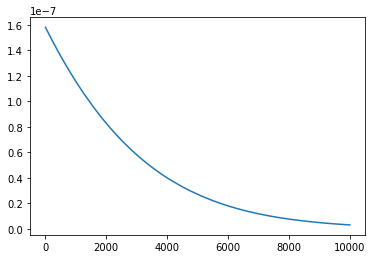

In [17]:
# define a loss function and train the neuron
def loss(weights, input_spikes, target):
    t_spike = spike_time(weights, tk)
    return (t_spike - target) ** 2

def update(weights, epoch, tk):
    value, grad = jax.value_and_grad(loss)(weights, tk, target)  
    weights = jax.tree_map(lambda f, df: f - lr * df, weights, grad)
    return weights, value

target = 0.006
lr = 10.0
tk = np.array([0., 5e-3])
weights = np.array([1.0, 1.0])
weights, loss_value = jax.lax.scan(partial(update, tk=tk), weights, np.arange(10000))
# %timeit jax.lax.scan(update, weights, np.arange(10000))
plt.plot(np.arange(10000), loss_value)
plt.show()

We already have two input spikes from two different weights. Now let's map this to two output neurons

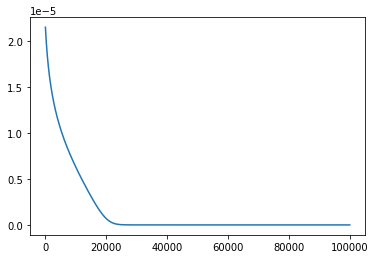

In [18]:
weights = np.array([[1.0, 1.0], [1.0, 1.0]])
n_epochs = 100_000
lr = 10.0

# define a new loss function
def loss(weights, batch):
    x, y = batch
    t_spike = spike_time(weights, x)
    return np.sum((t_spike - y) ** 2)

def update(weights, batch):
    value, grad = jax.value_and_grad(loss)(weights, batch)  
    weights = jax.tree_map(lambda f, df: f - lr * df, weights, grad)
    return weights, value

x = np.array([0., 5e-3])
y = np.array([0.001, 0.005])
input = (np.repeat(x[None,:], n_epochs, axis=0), np.repeat(y[None,:], n_epochs, axis=0))  
weights, loss_value = jax.lax.scan(update, weights, input)
plt.plot(np.arange(n_epochs), loss_value)
plt.show()

In [19]:
# now introduce a new loss function for ttfs
def loss_fn(t_spike, target):
    return np.sum((t_spike - target) **2)


def loss(weights, batch):
    x, y = batch
    t_spike = jax.vmap(spike_time, in_axes=(None, 0))(weights, x)
    return np.sum(jax.vmap(loss_fn, in_axes=(0, 0))(t_spike, y))

def acc(weights, batch):
    x, y = batch
    t_spike = jax.vmap(spike_time, in_axes=(None, 0))(weights, x)
    return np.sum(np.argmin(t_spike, axis=1) == np.argmin(y, axis=1)) / len(x)


def update(lr, weights, batch):
    value, grad = jax.value_and_grad(loss)(weights, batch)  
    grad = np.where(np.isnan(grad), 0, grad)
    weights = jax.tree_map(lambda f, df: f - lr * df, weights, grad)
    return weights, value

print(loss_fn(np.array([np.inf, np.inf]), np.array([0, 1])))
print(loss_fn(np.array([0.05, 0.9]), np.array([0, 1])))
print(loss_fn(np.array([0.001, 0.002]), np.array([0, 1])))


inf
0.012500005
0.99600506


In [22]:
import os
import sys

nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from jaxsnn.dataset.circle import CircleDataset, DataLoader

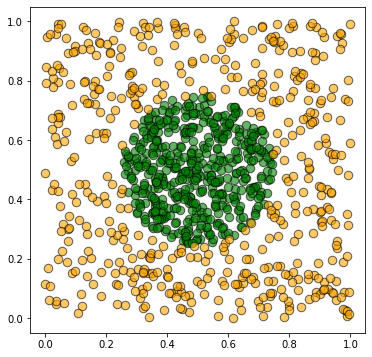

In [23]:
rng = jax.random.PRNGKey(42)
dataset = CircleDataset(rng, 1_000)
t_late = tau_syn + tau_mem
t_max = 2 * t_late

def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

def encode(input, target, batch_size = 10):
    input = input * t_late
    target = one_hot(target, 2)
    return input.reshape(batch_size, -1, 4), target.reshape(batch_size, -1, 2)

# let's look a the dataset
(input, target) = dataset.vals, dataset.classes
fig, ax = plt.subplots(figsize=(6, 6))
for color, data in zip(
    ("green", "orange"), (input[target == 0], input[target == 1])
):
    ax.scatter(
        data[:, 0],
        data[:, 1],
        c=color,
        s=plt.rcParams["lines.markersize"] ** 2.0 * 2,
        linewidths=1.0,
        edgecolors="black",
        alpha=0.6,
    )

plt.show()